In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import random

from nltk.corpus import stopwords
import string

from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

import preprocessor
from wordcloud import WordCloud
%matplotlib inline
pd.options.mode.chained_assignment = None

In [4]:
file_path = '/Users/Dracarys/Documents/data/'

In [5]:
hillary_df = pd.read_csv(file_path + 'hillary_no_duplicates.csv', low_memory=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,3,4,5,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
len(hillary_df)

12061097

In [76]:
sample = hillary_df[:10000]

In [16]:
wordcloud = WordCloud().generate(' '.join(sample.text) )

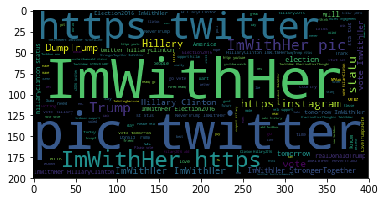

In [19]:
plt.imshow(wordcloud)

In [364]:
def display_top_words(vectorizer, documents, n=15):
    '''display the top n most important words for this vectorizer with given pandas Series'''
    matrix = vectorizer.fit_transform(documents)
    terms = vectorizer.get_feature_names()
    
    print('There are %d feature names.' % len(terms) )
    count = 0
    summation = -matrix.sum(axis=0)
    for index in np.argsort(summation).flat:
        count += 1
        if count > n:
            return
        
        print('%s \t %f' % (terms[index].ljust(25, ' '), -summation[0, index]) )

TfidfVectorizer in default's most important words.

In [365]:
tfidf = TfidfVectorizer()
%time display_top_words(tfidf, sample.text)

There are 19582 feature names.
imwithher                 	 782.006531
com                       	 429.632324
twitter                   	 397.291278
https                     	 312.836506
the                       	 290.479654
pic                       	 280.935333
vote                      	 277.124325
to                        	 270.142354
hillaryclinton            	 230.725707
for                       	 215.377475
you                       	 192.486849
is                        	 189.289294
and                       	 187.030363
status                    	 182.800880
hillary                   	 175.802695
CPU times: user 325 ms, sys: 11.6 ms, total: 336 ms
Wall time: 334 ms


Use TweetTokenizer

In [366]:
tknzr = TweetTokenizer()
tfidf = TfidfVectorizer(tokenizer=tknzr.tokenize)
%time display_top_words(tfidf, sample.text)

There are 22780 feature names.
/                         	 557.313642
#                         	 464.696998
.                         	 461.319736
#imwithher                	 454.403253
!                         	 424.447255
imwithher                 	 401.017891
:/                        	 282.708646
…                         	 272.088342
the                       	 271.584371
,                         	 264.139568
to                        	 251.612036
https                     	 227.009501
vote                      	 211.745219
for                       	 200.029774
i                         	 199.502967
CPU times: user 1.11 s, sys: 18.3 ms, total: 1.13 s
Wall time: 1.13 s


/, #, !, ... , these puntuation are not desired.

In [367]:
tfidf = TfidfVectorizer(tokenizer=tknzr.tokenize, stop_words='english')
%time display_top_words(tfidf, sample.text)

There are 22509 feature names.
/                         	 583.710269
.                         	 513.880135
#imwithher                	 500.446779
#                         	 476.807707
!                         	 466.096168
imwithher                 	 410.001138
:/                        	 296.644725
,                         	 296.281121
…                         	 284.667388
vote                      	 244.266130
https                     	 237.097250
tomorrow                  	 175.346647
"                         	 159.983150
http                      	 145.631685
hillary                   	 145.134126
CPU times: user 1.1 s, sys: 13.5 ms, total: 1.11 s
Wall time: 1.11 s


In [368]:
tfidf = TfidfVectorizer(tokenizer=lambda tweet: preprocessor.tokenize(tweet).split() ) 
%time display_top_words(tfidf, sample.text)

There are 16648 feature names.
$HASHTAG$                 	 1678.019103
$URL$                     	 622.188184
imwithher                 	 613.822118
$MENTION$                 	 411.518570
…                         	 370.011146
https://                  	 325.422242
the                       	 297.596751
to                        	 270.126803
for                       	 215.275988
$URL$.                    	 213.676930
i                         	 208.232457
a                         	 202.795156
vote                      	 189.111644
and                       	 187.505618
is                        	 185.137287
CPU times: user 1.5 s, sys: 18.8 ms, total: 1.52 s
Wall time: 1.54 s


In [369]:
tfidf = TfidfVectorizer(tokenizer=lambda tweet: preprocessor.tokenize(tweet).split(), stop_words='english') 
%time display_top_words(tfidf, sample.text)

There are 16387 feature names.
$HASHTAG$                 	 1788.781030
$URL$                     	 662.180351
imwithher                 	 624.609675
$MENTION$                 	 447.087062
…                         	 389.981770
https://                  	 343.029959
$URL$.                    	 228.006419
vote                      	 219.380343
http://                   	 194.501474
$NUMBER$                  	 145.123468
hillary                   	 136.954466
trump                     	 121.994240
i'm                       	 110.302977
tomorrow                  	 106.089634
&                         	 89.092574
CPU times: user 1.37 s, sys: 15.7 ms, total: 1.38 s
Wall time: 1.39 s


It seems this [tweet-preprocessor](https://pypi.python.org/pypi/tweet-preprocessor/0.4.0) will replace hastags, don't think it can serve for our purpose.

In [370]:
tfidf = TfidfVectorizer(tokenizer=tknzr.tokenize, stop_words=stopwords.words('english') + list(string.punctuation) )
%time display_top_words(tfidf, sample.text)

There are 22610 feature names.
#imwithher                	 508.173104
imwithher                 	 472.490125
:/                        	 305.592547
…                         	 294.252109
https                     	 244.995762
vote                      	 243.970588
tomorrow                  	 173.817100
http                      	 148.966294
hillary                   	 148.139119
#election2016             	 144.664177
status                    	 140.318550
@hillaryclinton           	 137.867856
https://www               	 132.961687
trump                     	 126.749688
i'm                       	 106.666459
CPU times: user 1.09 s, sys: 14.5 ms, total: 1.11 s
Wall time: 1.11 s


I think the problem is url recording. Let's see:

In [332]:
sample.text.apply(lambda x: print(x, '\n') if 'http' in x else 'Fine').value_counts()

Yes! #imwithher  #vote @Minneapolis-St Paul International Airport (MSP)  https://www. instagram.com/p/BMhzlbRAiGw/   

Just don't talk to me the next 36 hours. #ImWithHer  #TheGreatBlueWall  #CheetoHitlerOnTheBrain  @…  https://www. instagram.com/p/BMhzjo-D064/   

# ncvotes  #vote  #imwithher @Reynolds Coliseum  https://www. instagram.com/p/BMhzPsvgvO-/   

Fucking amazing. #pantsuitnation  #lovetrumpshate  #spinlove  #burninghearts  #tribe …  https://www. instagram.com/p/BMhzPU-g4-Q/   

Fucking amazing. #pantsuitnation  #lovetrumpshate  #spinlove …  https://www. instagram.com/p/BMhzGy6j-2pc hO2O5X1cHVlFXxUyq5xZQyibOE0/   … 

Let's make tomorrow count! #imwithher  #clintonkaine2016  #getoutandvote @Hillary for America…  https://www. instagram.com/p/BMhysmJlWh2/   

This was me trying to imagine what it would be like if Trump won but I couldn't. So, #ImWithHer .…  https://www. instagram.com/p/BMhy88pg-67/   

# imwithher  #nevertrump  #dumptrump  #luvnothate  #hillaryclintonforpreside


Shouldn't this tell everyone who to vote for? #ImWithHer   https:// twitter.com/vanityfair/sta tus/795762828590379008   … 

I wasn't being explicit before, but let's be honest: there's only 1 candidate who will support science & #ImWithHer   https:// twitter.com/sciam/status/7 95764076135776260   … 

# amwriting  about #Voting  because #ImWithHer   https:// maggiewritesstuff.wordpress.com/2016/11/07/vot e-dammit   … pic.twitter.com/oQJxKoX3FS 

# Hillary  Wraps Up Campaign With A Moving Video About How It All Began #ImWithHer  http://www. huffingtonpost.com/entry/hillary- clinton-campaign-video_us_58204840e4b0d9ce6fbd055a   … 

RELEASE: The Podesta Emails Part 33 #PodestaEmails  #PodestaEmails33  #HillaryClinton  #imWithHer …...  http:// ln.is/DlaGz    by #GunDecal 

# ImWithHer  #ElectionFinalThoughts  just made 30 #GOTV  calls from home in 30 minutes. You can, too https://www. hillaryclinton.com/calls/   

Republicans are now vowing Total War. And the consequences could be immense. 

Bernie FTW! #DumpTrump  #NeverTrump https:// twitter.com/berniesanders/ status/795737691535052800   … 

No brainer. #imwithher  #hillaryclinton2016  #hillary2016  #hillaryforpresident @Chinatown, Chicago  https://www. instagram.com/p/BMhqoD2lQLp/   

Hope  everyone makes it out to vote for equality tomorrow. #imwithher #outclique https:// twitter.com/jeneps/status/ 793835471247962118   … 

Why I am a Feminist (and other men should be too)  http:// ln.is/com/SKLRJ    via @femininecollect  @realDonaldTrump  #ImWithHer  #NeverTrump 

# Hillary  Gets Corrupt #Obama  #FBI  Pass For EMAILS ONLY BUT STILL INVESTIGATING FAKE CHARITY + OTHERS #Trump  #imwithher  #draintheswamp  #MAGA   https:// twitter.com/usa1trump/stat us/795689865849368576   … 

Electing a female President means imagining new possibilities." Comprehensive read before we vote & why #imwithher    http://www. newyorker.com/magazine/2016/ 10/31/the-new-yorker-endorses-hillary-clinton   …" 

Oh snap. How bad an hombre do you need

Bette is with @HillaryClinton , are you? #ImWithHer  #UseYourVote https:// twitter.com/bettemidler/st atus/794663404711661568   … 

# ImWithHer  4Prison! #Berner4Trump  #MAGA  #NeverHillary   https:// twitter.com/jaredwyand/sta tus/795031201362767872   … 

RELEASE: 8263 new emails from the DNC #DNCLeak2  #feelthebern  #imwithher  #demexit   http:// ln.is/X0YQr    ... by #LisaLoni14  via @c0nvey 

RT: Hillary Clinton’s Darkest Secrets Will Be Revealed -  http:// bit.ly/2faPhlq    #Hillary2016 

This gives me faith in humanity. #cnn  #ImWithHer   https:// twitter.com/CNN/status/795 689530171019265   … 

URGENT---> NC is VERY VERY close.You HAVE to vote for Hillary and other dems. Period. Or Trump will … #ImWithHer   http:// vitw.it/link/mmQYO   

@ MelanieScrofano  really does wear the best shirts ... #ImWithHer   https:// twitter.com/melaniescrofan o/status/795707899846819842   … 

@ seanhannity  @JudgeJeanine  @DonaldJTrumpJr  @realDonaldTrump  @JasonMillerinDC  #imwithher  #hillarycli

Not all #ReTHUGlicans  are as stupid as #Drumpf  and his #BasketOfDeplorables ! https:// twitter.com/ProgressWeekly /status/795730467228184576   … 

RELEASE: 8263 new emails from the DNC #DNCLeak2  #feelthebern  #imwithher  #demexit   http:// ln.is/nmnsX    ... by #WilliamJTV  via @c0nvey 

Rules of Engagement© #VetoHateCulture  © #ImWithHER   #LGBTQ  #BlackLives   https:// calililiindies.bandcamp.com/track/rules-of -engagement-ragtagraptag-cali-lili-cali-lili-indies-all-rights-reserved   …  #Hillary4Progress  #Noh8  @POTUS  @FLOTUS 

New @HillaryClinton  campaign ad featuring Beyoncé, Jay Z & more. http:// TIDAL.com/GetOutTheVote    #ImWithHer  #GetOutTheVote pic.twitter.com/CQULI1kbFp 

# rockthevote #ImWithHer   https:// twitter.com/HillaryClinton /status/795728304384917505   … 

I Ran the C.I.A. Now I’m Endorsing #HillaryClinton .  http:// nyti.ms/2aFaC1z    #Election2016  #ImWithHer  @CIA 

B/c Sally Kohn knows her stuff. Read and vote folks!! #ImWithHer   https:// twitter.com/sal

Fine    5694
Name: text, dtype: int64

In [339]:
test = [
    '''Yes! #imwithher  #vote @Minneapolis-St Paul International Airport (MSP)  https://www. instagram.com/p/BMhzlbRAiGw/   
''',
    '''# TrumpTerror  #OrangeHitler  #PA  #MO  #CO  #OH  #Ohio  #AZ  #UT  #FL  #Florida  #NV  #NH  #NC  #TX  #WY  #IA  #MO  #WI  #MI  #ImWithHER  #SheWhoVotes  #GoHillary https:// twitter.com/absolutdm/stat us/795769476427808768   … 
''',
    '''Sound familiar? #truestory  #ImWithHer  #IveAlwaysBeenWithHer  #MisogynyRunAmok   https:// shar.es/1I4066    via @sharethis 
''',
    '''RELEASE: 8263 new emails from the DNC #DNCLeak2  #feelthebern  #imwithher ...  http:// ln.is/n7px8    by #realjunsonchan  via @c0nvey 
'''
]

In [353]:
for t in test:
    print(t)
    print(re.sub('http([^(#|@)])+', '', t))
    print()

Yes! #imwithher  #vote @Minneapolis-St Paul International Airport (MSP)  https://www. instagram.com/p/BMhzlbRAiGw/   

Yes! #imwithher  #vote @Minneapolis-St Paul International Airport (MSP)  

# TrumpTerror  #OrangeHitler  #PA  #MO  #CO  #OH  #Ohio  #AZ  #UT  #FL  #Florida  #NV  #NH  #NC  #TX  #WY  #IA  #MO  #WI  #MI  #ImWithHER  #SheWhoVotes  #GoHillary https:// twitter.com/absolutdm/stat us/795769476427808768   … 

# TrumpTerror  #OrangeHitler  #PA  #MO  #CO  #OH  #Ohio  #AZ  #UT  #FL  #Florida  #NV  #NH  #NC  #TX  #WY  #IA  #MO  #WI  #MI  #ImWithHER  #SheWhoVotes  #GoHillary 

Sound familiar? #truestory  #ImWithHer  #IveAlwaysBeenWithHer  #MisogynyRunAmok   https:// shar.es/1I4066    via @sharethis 

Sound familiar? #truestory  #ImWithHer  #IveAlwaysBeenWithHer  #MisogynyRunAmok   @sharethis 


RELEASE: 8263 new emails from the DNC #DNCLeak2  #feelthebern  #imwithher ...  http:// ln.is/n7px8    by #realjunsonchan  via @c0nvey 

RELEASE: 8263 new emails from the DNC #DNCLeak2  #feel

I think we could use regular pattern to get rid of the urls. I think the urls are not so important in general and might cold have add a lot of noises data into the features columns fater tfidf it. One obvious pattern we could see is that url is usually at the end of the tweets. Therefore, I will just get rid of all part that started with http until we saw either a # for hashtag or @ for at

In [356]:
def remove_url(tweet):
    return re.sub('http([^(#|@)])+', '', tweet)

In [357]:
sample['no_url'] = sample.text.apply(remove_url)

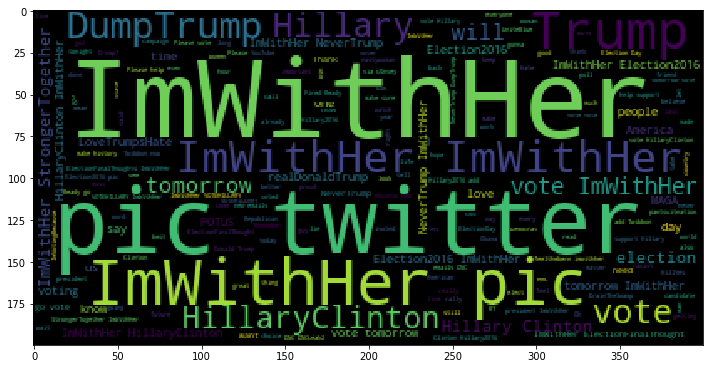

In [362]:
wordcloud = WordCloud().generate(' '.join(sample.no_url) )
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)

In [371]:
tfidf = TfidfVectorizer(tokenizer=tknzr.tokenize, stop_words=stopwords.words('english') + list(string.punctuation) )
%time display_top_words(tfidf, sample.no_url)

There are 15606 feature names.
#imwithher                	 611.830040
imwithher                 	 610.575234
vote                      	 270.873167
tomorrow                  	 184.232899
hillary                   	 170.352711
#election2016             	 166.472140
@hillaryclinton           	 152.150509
trump                     	 139.618372
#strongertogether         	 125.866215
#dumptrump                	 125.482503
#hillary2016              	 119.526369
#nevertrump               	 118.087197
#vote                     	 116.668829
i'm                       	 113.526592
go                        	 108.088184
CPU times: user 916 ms, sys: 13 ms, total: 929 ms
Wall time: 945 ms


In [373]:
tknzr = TweetTokenizer()
wnl = WordNetLemmatizer()
remove_chars = stopwords.words('english') + list(string.punctuation)

def lemmatize(text):
    '''lemmatiz text'''
    return [ wnl.lemmatize(word) for word in tknzr.tokenize(text)]

In [374]:
tfidf = TfidfVectorizer(tokenizer=lemmatize, stop_words=remove_chars)
%time display_top_words(tfidf, sample.no_url)

There are 14909 feature names.
#imwithher                	 617.805030
imwithher                 	 611.208138
vote                      	 276.670974
tomorrow                  	 187.084602
hillary                   	 172.237079
#election2016             	 167.888290
@hillaryclinton           	 153.011458
trump                     	 144.330522
#strongertogether         	 126.602039
#dumptrump                	 126.506369
#hillary2016              	 120.307996
#nevertrump               	 119.043087
#vote                     	 117.529699
i'm                       	 114.581635
go                        	 111.240320
CPU times: user 1.97 s, sys: 90.3 ms, total: 2.06 s
Wall time: 2.09 s


Looking at this word rank list, I think tfidf is doing pretty good.

In [375]:
eng_stemmer = EnglishStemmer()

def stem_words(text):
    '''use stemmber'''
    return [ eng_stemmer.stem(word) for word in tknzr.tokenize(text)]

In [377]:
tfidf = TfidfVectorizer(tokenizer=stem_words, stop_words=remove_chars)
%time display_top_words(tfidf, sample.no_url)

There are 13600 feature names.
#imwithh                  	 627.860199
imwithh                   	 611.527787
vote                      	 342.493252
tomorrow                  	 194.525876
hillari                   	 179.738613
#election2016             	 169.834123
@hillaryclinton           	 155.317453
trump                     	 152.906500
go                        	 134.973729
#dumptrump                	 130.096760
#strongertogeth           	 128.524986
#hillary2016              	 122.005546
#vote                     	 121.344534
#nevertrump               	 120.937051
i'm                       	 117.186435
CPU times: user 3.82 s, sys: 38 ms, total: 3.85 s
Wall time: 3.89 s


In [378]:
eng_stemmer = EnglishStemmer(ignore_stopwords=True)

def stem_words(text):
    '''use stemmber'''
    return [ eng_stemmer.stem(word) for word in tknzr.tokenize(text)]

In [381]:
tfidf = TfidfVectorizer(tokenizer=stem_words, stop_words=remove_chars)
%time display_top_words(tfidf, sample.no_url)

There are 13587 feature names.
#imwithh                  	 633.507699
imwithh                   	 613.172141
vote                      	 344.321243
tomorrow                  	 195.381934
hillari                   	 180.385318
#election2016             	 170.481718
@hillaryclinton           	 156.191717
trump                     	 153.576736
go                        	 135.610151
#dumptrump                	 130.693979
#strongertogeth           	 128.867236
#hillary2016              	 122.153795
#vote                     	 121.953680
#nevertrump               	 121.272688
i'm                       	 118.471548
CPU times: user 3.31 s, sys: 30.1 ms, total: 3.34 s
Wall time: 3.37 s


SnowballStemmer and WordNetLemmatizer both could trim the words. Base on running time, WordNetLemmatizer is faster.

In [382]:
s = 'hillary'
eng_stemmer.stem(s), wnl.lemmatize(s)

('hillari', 'hillary')

One thing I don't like snowball stemmer, is it changes hillary to hillari, don't know why (is hillari an adjective??)

Let's try to cluster with NMF (note, this is polynomial time) and LDA (running time proportional to (n_samepls * iterations) )

Let's use make tfidf_vectorizer with lemmatize tokenizer, max_df=.95: ignore terms having a document frequency of .95; min_df=2: ignore terms that has less than 2 occurances overall documents

In [399]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, stop_words=remove_chars, max_df=.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(sample.no_url)

In [405]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [401]:
%time nmf = NMF().fit(tfidf)

KeyboardInterrupt: 

NMF takes too long to finish for just 10000 rows.

In [402]:
lda = LatentDirichletAllocation()
%time lda.fit(tfidf)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 17 s, sys: 522 ms, total: 17.5 s
Wall time: 17.7 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

Let's see how lda's default group top 10000 hillry's tweets (no_url version):

In [415]:
for topic_idx, topic in enumerate(lda.components_):
    print('topic:', topic_idx)
    for index in np.argsort(-topic)[:15]:
        print('%s: %f' % (tfidf_feature_names[index].ljust(25, ' '), topic[index] ) )
    print()

topic: 0
hillaryclinton           : 41.408065
could                    : 35.593899
#imwithher               : 33.083692
got                      : 26.067690
#blacklivesmatter        : 23.636543
#strongertogether        : 23.631755
#uniteblue               : 21.771498
@youtube                 : 21.453868
hrc                      : 18.537377
wish                     : 17.627328
#nevertrump              : 16.868246
true                     : 16.736506
#love                    : 15.508411
rally                    : 15.454905
said                     : 15.395529

topic: 1
imwithher                : 770.126628
even                     : 30.226914
#strongertogether        : 26.231185
#imwithher2016           : 20.423475
#votehillary             : 17.278396
#gohillary               : 16.295657
#blm                     : 15.585657
truth                    : 13.307425
hillary's                : 11.757476
@hfa                     : 10.417300
join                     : 10.100254
latino            

Peeking at the most weighted words, I think "(leftward), "(rightward) ... these should not be appeared. Not sure why the are not removed from remove_chars list?

In [418]:
' '.join(remove_chars)

'i me my myself we our ours ourselves you your yours yourself yourselves he him his himself she her hers herself it its itself they them their theirs themselves what which who whom this that these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don should now d ll m o re ve y ain aren couldn didn doesn hadn hasn haven isn ma mightn mustn needn shan shouldn wasn weren won wouldn ! " # $ % & \' ( ) * + , - . / : ; < = > ? @ [ \\ ] ^ _ ` { | } ~'

[Use k means](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html)

In [466]:
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
%time lsa = make_pipeline(svd, normalizer)

CPU times: user 171 µs, sys: 1e+03 ns, total: 172 µs
Wall time: 175 µs


In [428]:
X = lsa.fit_transform(tfidf)

In [465]:
km = MiniBatchKMeans()
%time km.fit(X)

CPU times: user 37.4 ms, sys: 2.1 ms, total: 39.5 ms
Wall time: 37.7 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [459]:
def k_means_top_words(matrix, feature_names, n_clusters, labels, n=15):
    '''display the top n most important words for this k means model'''
    for i in range(n_clusters):
        print('group: %d', i)
        current_group = labels == i
        feature_weights = matrix[current_group].sum(axis=0)
        count = 0
        for j in np.argsort(-feature_weights).flat:
            count += 1
            if count > n:
                break
            print('%s \t %f' %(feature_names[j].ljust(25, ' '), feature_weights[0, j]) )

In [460]:
k_means_top_words(tfidf, tfidf_feature_names, km.n_clusters, km.labels_)

group: %d 0
#imwithher                	 157.131454
vote                      	 103.293659
hillary                   	 76.802556
@hillaryclinton           	 76.093216
#nevertrump               	 72.365649
#vote                     	 68.611787
trump                     	 65.177677
#electionfinalthoughts    	 64.435276
tomorrow                  	 61.753549
#hillary2016              	 60.704122
clinton                   	 56.907287
#dumptrump                	 54.990394
please                    	 52.035315
#hillaryclinton           	 46.461757
#election2016             	 42.597216
group: %d 1
imwithher                 	 75.566602
@hillaryclinton           	 14.622470
#strongertogether         	 14.172853
#election2016             	 12.773272
#vote                     	 9.207137
#nevertrump               	 7.448022
#blacklivesmatter         	 5.587504
#votehillary              	 4.738003
#hillaryclinton           	 4.708262
#maga                     	 4.673649
#magax3                   	 4.

In [463]:
kmeans = KMeans()
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [464]:
k_means_top_words(tfidf, tfidf_feature_names, kmeans.n_clusters, kmeans.labels_)

group: %d 0
#imwithher                	 577.986692
vote                      	 203.908135
tomorrow                  	 151.257909
hillary                   	 122.485853
trump                     	 97.538179
please                    	 95.196893
clinton                   	 83.801511
election                  	 83.378258
i'm                       	 82.747087
go                        	 82.067602
...                       	 69.396526
make                      	 66.286130
don't                     	 59.824817
right                     	 56.999468
america                   	 56.631956
group: %d 1
imwithher                 	 632.782918
#votehillary              	 6.865034
#hillaryclintonforpresident 	 6.740143
#imwithher2016            	 3.938252
#hillary2016              	 3.246589
#hillaryclinton           	 2.786026
#nevertrump               	 2.713808
4                         	 2.633188
#gohillary                	 2.463894
#electionfinalthoughts    	 2.391912
#govote                   	 

I think k-means is a decent method for this unsupervised clustering. (Simply because this is quite fast.. and considering the dataset we are going to cluster..)

There is a python library [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html), and there is a sentiment mothod return tuple of (polarity, subjectivity)

In [472]:
from textblob import TextBlob

In [481]:
testimonial = TextBlob("I think you are awesome")
testimonial.sentiment.polarity, testimonial.sentiment_assessments.subjectivity

(1.0, 1.0)

In [482]:
testimonial = TextBlob("I am very very sad")
testimonial.sentiment.polarity, testimonial.sentiment_assessments.subjectivity

(-0.65, 1.0)

In [485]:
testimonial = TextBlob("He thinks that, she thinks that etc...")
testimonial.sentiment.polarity, testimonial.sentiment_assessments.subjectivity

(0.0, 0.0)

In [486]:
def get_sentiment_score(tweet):
    testimonial = TextBlob(tweet)
    return testimonial.sentiment.polarity, testimonial.sentiment_assessments.subjectivity

In [489]:
%time sample['sentiment'] = sample.no_url.apply(get_sentiment_score)

CPU times: user 17.9 s, sys: 167 ms, total: 18.1 s
Wall time: 18.2 s


Let's sample some to see how this sentiment analysis works:

In [497]:
for index, rows in sample.iterrows():
    if random.random() > .97:
        print(rows.no_url)
        print(rows.sentiment)
        print()

# ImVotingBecause  These BRAVE women stood up & demanded to be heard. Thank YOU! I'm a WOMAN & I VOTE! #ImWithHer   pic.twitter.com/boyGVN1WvW
(1.0, 1.0)

The next 24 hours determines so much. Just keep knocking on wood, folks. #ImWithHer  #StrongerTogether  #HillToTheHouse
(0.1, 0.1)

.@BarackObama  Can I boo after I vote? #ImWithHer
(0.0, 0.0)

Retweeted HILLARY 2016 (@simplymarcoo ):RWETEET IF YOU HAVE OR WILL VOTE @HillaryClinton  #ImWithHer  #ShesWithUs ...  
(0.0, 0.0)

LOL Rudy. Trump quotes are probably the LAST thing you want to be highlighting. #ImWithHer   
(0.4, 0.3833333333333333)

I'm Ben Deutsch, and I approve this message. #imwithher Watch Hillary Clinton's final campaign ad  
(0.0, 1.0)

Coffee, #DumpTrump , & a @JamesVictore  designed shirt. Grab yours here:  @realDonaldTrump . pic.twitter.com/84rlbRnKfs
(0.0, 0.0)

Wow.#ImWithHer   
(0.0, 0.0)

Pot / kettle. Stupid. #dumptrump  #NeverTrump 
(-0.7999999999999999, 1.0)

# Media  focused on Hillary Clinton's email witch

Such an amazing experience #ImWithHer   pic.twitter.com/qxXf2u33Ec
(0.30000000000000004, 0.7)

@ tvc3232  @Lesliegy  WashPost fact checkers: HRC had highest false statement rating of 4 Pinocchio's 7x's to DT's whopping 59x's! #ImWithHer   pic.twitter.com/nJf72peXHY
(-0.5000000000000001, 0.6)

Overseas Voters.  If you need help there's a Website you can go to! #StrongerTogether  #Imwithher  #UnitedDemHQ pic.twitter.com/FWHJJQzcgR
(0.0, 0.0)

These tweets r so boring please giv Donhis phone back! No more #MakeAmericaGropeAgain  because #ImWithHer
(-0.4166666666666667, 0.5)

# LoveTrumpsHate   #NeverTrump  #dumptrump  #GOTV 
(0.0, 0.0)

# LoveTrumpsHate  DonaldtrumpsCorruption
(0.0, 0.0)

# VoteLGBT  so we all have a seat at the table. Great work @VictoryFund . #LGBT  #LGBTQ  #ImWithHer  #StrongerTogether pic.twitter.com/NdjDJYpqCO
(0.8, 0.75)

Hillary's a politician. I dislike politicians but I'd do anything to have a politician for Prez over a racist reality TV clown so #ImWithHer
(0.0,

In [395]:
# to_csv('temp.csv', index=False, header=True)